## **Using VGG16**


In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 4
NUM_EPOCHS = 5
NUM_CLASSES = 2

In [30]:
train_data_dir = '/Users/mayurpatowary/Desktop/Project/Research Paper/chest_xray/train'
validation_data_dir = '/Users/mayurpatowary/Desktop/Project/Research Paper/chest_xray/test' #the test set in the folder is actually used as the validation dataset and val set in the drive used as test dataset

In [31]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [43]:
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))

In [44]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(NUM_CLASSES, activation = 'softmax'))

In [45]:
for layer in base_model.layers:
    layer.trainable = False

In [40]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [47]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // BATCH_SIZE
)

model.save('pneumonia_detection_model_vgg16.h5')

Epoch 1/5
1304/1304 [==============================] - 602s 461ms/step - loss: 2.2929 - accuracy: 0.9402 - val_loss: 0.2713 - val_accuracy: 0.9327
Epoch 2/5
1304/1304 [==============================] - 668s 513ms/step - loss: 0.1375 - accuracy: 0.9624 - val_loss: 0.2534 - val_accuracy: 0.9183
Epoch 3/5
1304/1304 [==============================] - 698s 535ms/step - loss: 0.1185 - accuracy: 0.9643 - val_loss: 0.3499 - val_accuracy: 0.9103
Epoch 4/5
1304/1304 [==============================] - 724s 555ms/step - loss: 0.1325 - accuracy: 0.9630 - val_loss: 0.2503 - val_accuracy: 0.9183
Epoch 5/5
1304/1304 [==============================] - 734s 563ms/step - loss: 0.0992 - accuracy: 0.9676 - val_loss: 0.2513 - val_accuracy: 0.9135


/Users/mayurpatowary/desktop/Project/env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = load_model('pneumonia_detection_model_vgg16.h5')

In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

image_path = '/Users/mayurpatowary/Desktop/Project/Research Paper/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg'

preprocessed_image = preprocess_image(image_path)

prediction = model.predict(preprocessed_image)

class_label = np.argmax(prediction) #(0: 'Normal', 1: 'Pneumonia')

class_prob = prediction[0][class_label]

if class_label == 0:
    print("Predicted class: Normal")
else:
    print("Predicted class: Pneumonia")

print("Predicted probability: {:.2f}%".format(class_prob * 100))


1/1 [==============================] - 0s 163ms/step
Predicted class: Pneumonia
Predicted probability: 65.93%


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

validation_steps = validation_generator.n // BATCH_SIZE
y_true = []
y_pred = []

for i in range(validation_steps):
    x_val, y_val = validation_generator.next()
    y_true.extend(np.argmax(y_val, axis = 1))
    y_pred.extend(np.argmax(model.predict(x_val), axis = 1))

confusion_mat = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'])

print("Confusion Matrix:")
print(confusion_mat)

print("\nClassification Report:")
print(classification_rep)


1/1 [==============================] - 0s 399ms/step
Confusion Matrix:
[[212  22]
 [ 32 358]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.87      0.91      0.89       234
   Pneumonia       0.94      0.92      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624



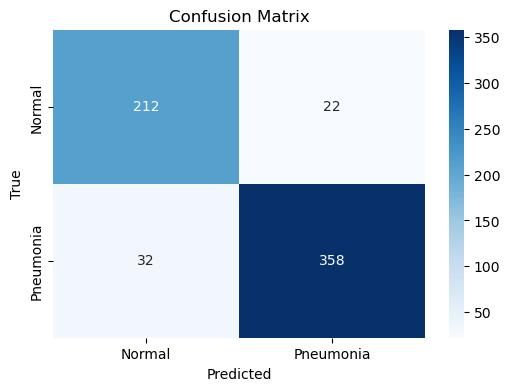

In [15]:
import seaborn as sns
import matplotlib.pyplot as plot

class_labels = ['Normal', 'Pneumonia']

plot.figure(figsize = (6, 4))
sns.heatmap(confusion_mat, annot = True, fmt='d', cmap='Blues', xticklabels = class_labels, yticklabels=class_labels)

plot.xlabel('Predicted')
plot.ylabel('True')
plot.title('Confusion Matrix')
plot.xticks(np.arange(NUM_CLASSES) + 0.5, class_labels)
plot.yticks(np.arange(NUM_CLASSES) + 0.5, class_labels)

plot.show()

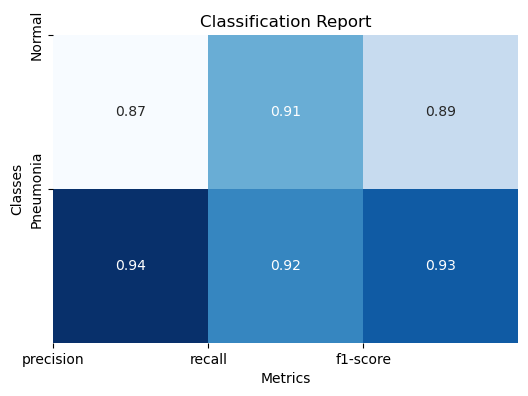

In [16]:
report = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'], output_dict = True)

metrics = ['precision', 'recall', 'f1-score']
heatmap_data = []
for label in class_labels:
    heatmap_data.append([report[label][metric] for metric in metrics])

plot.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot = True, cmap = 'Blues', fmt = '.2f', cbar = False)

plot.xlabel('Metrics')
plot.ylabel('Classes')
plot.title('Classification Report')
plot.xticks(np.arange(len(metrics)), metrics)
plot.yticks(np.arange(NUM_CLASSES), class_labels)

plot.show()

## **Using VGG19**


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 4
NUM_EPOCHS = 5
NUM_CLASSES = 2

In [3]:
train_data_dir = '/Users/mayurpatowary/Desktop/Project/Research Paper/chest_xray/train'
validation_data_dir = '/Users/mayurpatowary/Desktop/Project/Research Paper/chest_xray/test' #the test set in the folder is actually used as the validation dataset and val set in the drive used as test dataset

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
base_model = VGG19(weights = 'imagenet', include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))

80134624/80134624 [==============================] - 164s 2us/step


In [6]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(NUM_CLASSES, activation = 'softmax'))

In [7]:
for layer in base_model.layers:
    layer.trainable = False

In [8]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [9]:
model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // BATCH_SIZE
)

model.save('pneumonia_detection_model_vgg19.h5')

Epoch 1/5
1304/1304 [==============================] - 800s 613ms/step - loss: 2.5610 - accuracy: 0.9360 - val_loss: 0.2589 - val_accuracy: 0.8974
Epoch 2/5
1304/1304 [==============================] - 847s 649ms/step - loss: 0.1048 - accuracy: 0.9686 - val_loss: 0.5234 - val_accuracy: 0.9135
Epoch 3/5
1304/1304 [==============================] - 865s 664ms/step - loss: 0.1053 - accuracy: 0.9643 - val_loss: 0.1850 - val_accuracy: 0.9263
Epoch 4/5
1304/1304 [==============================] - 928s 712ms/step - loss: 0.1113 - accuracy: 0.9682 - val_loss: 0.3278 - val_accuracy: 0.9103
Epoch 5/5
1304/1304 [==============================] - 941s 722ms/step - loss: 0.0942 - accuracy: 0.9714 - val_loss: 0.2909 - val_accuracy: 0.9006


/Users/mayurpatowary/desktop/Project/env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('pneumonia_detection_model_vgg19.h5')

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

image_path = '/Users/mayurpatowary/Desktop/Project/Research Paper/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'

preprocessed_image = preprocess_image(image_path)

prediction = model.predict(preprocessed_image)

class_label = np.argmax(prediction) #(0: 'Normal', 1: 'Pneumonia')

class_prob = prediction[0][class_label]

if class_label == 0:
    print("Predicted class: Normal")
else:
    print("Predicted class: Pneumonia")

print("Predicted probability: {:.2f}%".format(class_prob * 100))


1/1 [==============================] - 0s 204ms/step
Predicted class: Normal
Predicted probability: 91.71%


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

validation_steps = validation_generator.n // BATCH_SIZE
y_true = []
y_pred = []

for i in range(validation_steps):
    x_val, y_val = validation_generator.next()
    y_true.extend(np.argmax(y_val, axis=1))
    y_pred.extend(np.argmax(model.predict(x_val), axis=1))

confusion_mat = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'])

print("Confusion Matrix:")
print(confusion_mat)

print("\nClassification Report:")
print(classification_rep)


1/1 [==============================] - 1s 523ms/step
Confusion Matrix:
[[183  51]
 [ 11 379]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.78      0.86       234
   Pneumonia       0.88      0.97      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



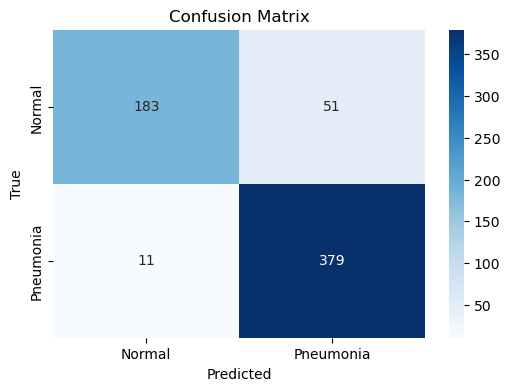

In [16]:
import seaborn as sns
import matplotlib.pyplot as plot
class_labels = ['Normal', 'Pneumonia']

plot.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_labels, yticklabels = class_labels)

plot.xlabel('Predicted')
plot.ylabel('True')
plot.title('Confusion Matrix')
plot.xticks(np.arange(NUM_CLASSES) + 0.5, class_labels)
plot.yticks(np.arange(NUM_CLASSES) + 0.5, class_labels)

plot.show()

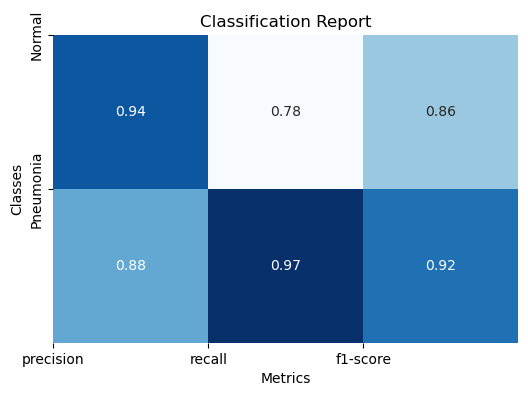

In [17]:
import pandas as pd

report = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'], output_dict = True)

metrics = ['precision', 'recall', 'f1-score']
heatmap_data = []
for label in class_labels:
    heatmap_data.append([report[label][metric] for metric in metrics])

plot.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.2f', cbar=False)

plot.xlabel('Metrics')
plot.ylabel('Classes')
plot.title('Classification Report')
plot.xticks(np.arange(len(metrics)), metrics)
plot.yticks(np.arange(NUM_CLASSES), class_labels)

plot.show()

## **Using ResNet-50**


In [23]:
import numpy as np
import matplotlib.pyplot as plot
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 4
NUM_EPOCHS = 5
NUM_CLASSES = 2

In [11]:
train_data_dir = '/Users/mayurpatowary/Desktop/Project/Research Paper/chest_xray/train'
validation_data_dir = '/Users/mayurpatowary/Desktop/Project/Research Paper/chest_xray/test'  #the test set in the folder is actually used as the validation dataset and val set in the drive used as test dataset

In [12]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
base_model = ResNet50(weights='imagenet', include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))

In [14]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [15]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(NUM_CLASSES, activation = 'softmax'))

In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 49278594 (187.98 MB)
Trainable params: 25690882 (98.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [67]:
model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // BATCH_SIZE
)

model.save('pneumonia_detection_model_resnet50.h5')

Epoch 1/5
1304/1304 [==============================] - 244s 186ms/step - loss: 1.2208 - accuracy: 0.9408 - val_loss: 0.6150 - val_accuracy: 0.8029
Epoch 2/5
1304/1304 [==============================] - 275s 211ms/step - loss: 0.0976 - accuracy: 0.9682 - val_loss: 0.3251 - val_accuracy: 0.8766
Epoch 3/5
1304/1304 [==============================] - 279s 214ms/step - loss: 0.1046 - accuracy: 0.9693 - val_loss: 0.2814 - val_accuracy: 0.8990
Epoch 4/5
1304/1304 [==============================] - 283s 217ms/step - loss: 0.1132 - accuracy: 0.9695 - val_loss: 0.3245 - val_accuracy: 0.9199
Epoch 5/5
1304/1304 [==============================] - 272s 208ms/step - loss: 0.0752 - accuracy: 0.9757 - val_loss: 0.2821 - val_accuracy: 0.9199


/Users/mayurpatowary/desktop/Project/env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = load_model('pneumonia_detection_model_resnet50.h5')

In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

image_path = '/Users/mayurpatowary/Desktop/Project/Research Paper/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg'

preprocessed_image = preprocess_image(image_path)

prediction = model.predict(preprocessed_image)

class_label = np.argmax(prediction) #(0: 'Normal', 1: 'Pneumonia') 

class_prob = prediction[0][class_label]

if class_label == 0:
    print("Predicted class: Normal")
else:
    print("Predicted class: Pneumonia")

print("Predicted probability: {:.2f}%".format(class_prob * 100))


1/1 [==============================] - 0s 475ms/step
Predicted class: Pneumonia
Predicted probability: 99.80%


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

validation_steps = validation_generator.n // BATCH_SIZE
y_true = []
y_pred = []

for i in range(validation_steps):
    x_val, y_val = validation_generator.next()
    y_true.extend(np.argmax(y_val, axis = 1))
    y_pred.extend(np.argmax(model.predict(x_val), axis = 1))

confusion_mat = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'])

print("Confusion Matrix:")
print(confusion_mat)

print("\nClassification Report:")
print(classification_rep)


1/1 [==============================] - 0s 130ms/step
Confusion Matrix:
[[200  34]
 [ 16 374]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.85      0.89       234
   Pneumonia       0.92      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



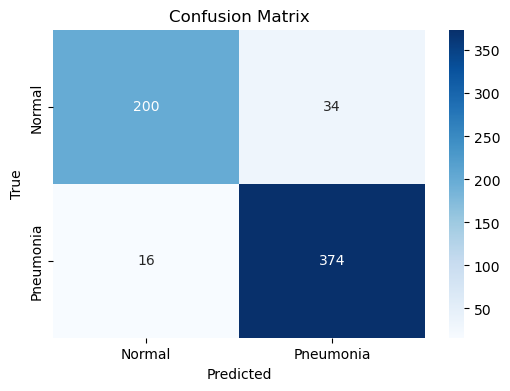

In [24]:
import seaborn as sns
class_labels = ['Normal', 'Pneumonia']

plot.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot = True, fmt='d', cmap='Blues', xticklabels = class_labels, yticklabels=class_labels)

plot.xlabel('Predicted')
plot.ylabel('True')
plot.title('Confusion Matrix')
plot.xticks(np.arange(NUM_CLASSES) + 0.5, class_labels)
plot.yticks(np.arange(NUM_CLASSES) + 0.5, class_labels)

plot.show()

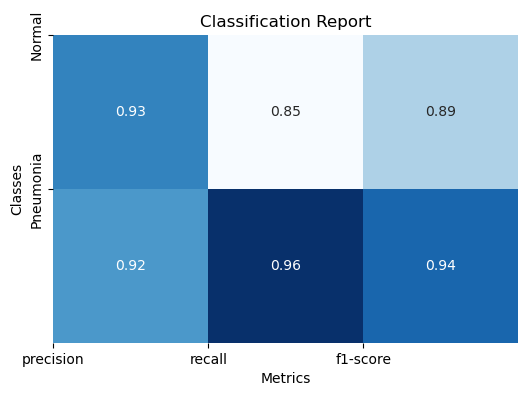

In [25]:
import pandas as pd

report = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'], output_dict = True)

metrics = ['precision', 'recall', 'f1-score']
heatmap_data = []
for label in class_labels:
    heatmap_data.append([report[label][metric] for metric in metrics])

plot.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.2f', cbar=False)

plot.xlabel('Metrics')
plot.ylabel('Classes')
plot.title('Classification Report')
plot.xticks(np.arange(len(metrics)), metrics)
plot.yticks(np.arange(NUM_CLASSES), class_labels)

plot.show()

## **Using CondenseNet**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 4
NUM_EPOCHS = 5
NUM_CLASSES = 2

In [3]:
train_data_dir = '/Users/mayurpatowary/Desktop/Project/Research Paper/chest_xray/train'
validation_data_dir = '/Users/mayurpatowary/Desktop/Project/Research Paper/chest_xray/test'  #the test set in the folder is actually used as the validation dataset and val set in the drive used as test dataset

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
def dense_block(input_tensor, growth_rate, num_layers):
    for i in range(num_layers):
        x = BatchNormalization()(input_tensor)
        x = Activation('relu')(x)
        x = Conv2D(growth_rate, kernel_size=(3,3), padding='same')(x)
        input_tensor = Concatenate()([input_tensor, x])
    return input_tensor


def transition_layer(input_tensor, compression_factor):
    num_channels = int(input_tensor.shape[-1])
    num_channels = int(num_channels * compression_factor)
    x = BatchNormalization()(input_tensor)
    x = Conv2D(num_channels, kernel_size=(1,1), padding='same')(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    return x

def CondenseNet(input_shape, growth_rate=12, compression_factor=0.5, num_blocks=[6, 12, 24, 16], num_classes=2):
    input_tensor = Input(shape=input_shape)
    x = Conv2D(2 * growth_rate, kernel_size=(7,7), padding='same', strides=(2,2))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

    num_filters = 2 * growth_rate
    for i, num_layers in enumerate(num_blocks):
        x = dense_block(x, growth_rate, num_layers)
        if i != len(num_blocks) - 1:
            x = transition_layer(x, compression_factor)
            num_filters = int(num_filters * compression_factor)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(input_tensor, x)
    return model

In [8]:
input_shape = (224, 224, 3)
model = CondenseNet(input_shape)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 24)         3552      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 24)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 24)         0         ['batch_normalization[0][0

In [12]:
model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // BATCH_SIZE
)

model.save('pneumonia_detection_model_condense.h5')

Epoch 1/5
1304/1304 [==============================] - 248s 188ms/step - loss: 0.3370 - accuracy: 0.8530 - val_loss: 8.7028 - val_accuracy: 0.6250
Epoch 2/5
1304/1304 [==============================] - 249s 191ms/step - loss: 0.2764 - accuracy: 0.8863 - val_loss: 0.5619 - val_accuracy: 0.7981
Epoch 3/5
1304/1304 [==============================] - 265s 203ms/step - loss: 0.2450 - accuracy: 0.9053 - val_loss: 1.5299 - val_accuracy: 0.6779
Epoch 4/5
1304/1304 [==============================] - 266s 204ms/step - loss: 0.2135 - accuracy: 0.9164 - val_loss: 0.6961 - val_accuracy: 0.7596
Epoch 5/5
1304/1304 [==============================] - 269s 206ms/step - loss: 0.1838 - accuracy: 0.9294 - val_loss: 0.9661 - val_accuracy: 0.7420


/Users/mayurpatowary/desktop/Project/env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = load_model('pneumonia_detection_model_condense.h5')

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

validation_steps = validation_generator.n // BATCH_SIZE
y_true = []
y_pred = []

for i in range(validation_steps):
    x_val, y_val = validation_generator.next()
    y_true.extend(np.argmax(y_val, axis = 1))
    y_pred.extend(np.argmax(model.predict(x_val), axis = 1))

confusion_mat = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'])

print("Confusion Matrix:")
print(confusion_mat)

print("\nClassification Report:")
print(classification_rep)


1/1 [==============================] - 0s 50ms/step
Confusion Matrix:
[[ 75 160]
 [  2 387]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.32      0.48       235
   Pneumonia       0.71      0.99      0.83       389

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.65       624
weighted avg       0.81      0.74      0.70       624



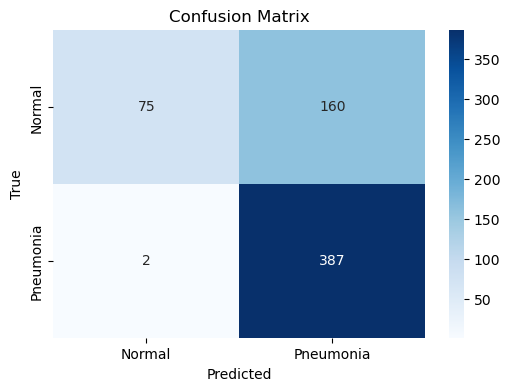

In [16]:
import matplotlib.pyplot as plot
import seaborn as sns
class_labels = ['Normal', 'Pneumonia']

plot.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot = True, fmt='d', cmap='Blues', xticklabels = class_labels, yticklabels=class_labels)

plot.xlabel('Predicted')
plot.ylabel('True')
plot.title('Confusion Matrix')
plot.xticks(np.arange(NUM_CLASSES) + 0.5, class_labels)
plot.yticks(np.arange(NUM_CLASSES) + 0.5, class_labels)

plot.show()

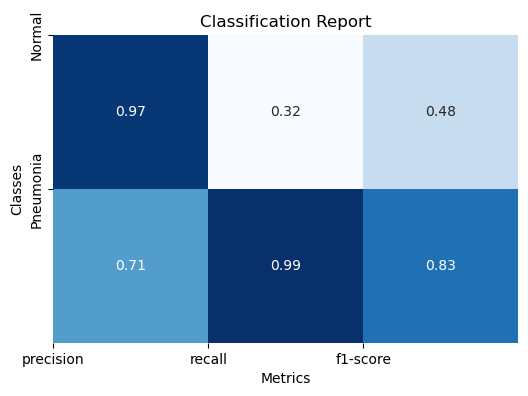

In [17]:
import pandas as pd

report = classification_report(y_true, y_pred, target_names = ['Normal', 'Pneumonia'], output_dict = True)

metrics = ['precision', 'recall', 'f1-score']
heatmap_data = []
for label in class_labels:
    heatmap_data.append([report[label][metric] for metric in metrics])

plot.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.2f', cbar=False)

plot.xlabel('Metrics')
plot.ylabel('Classes')
plot.title('Classification Report')
plot.xticks(np.arange(len(metrics)), metrics)
plot.yticks(np.arange(NUM_CLASSES), class_labels)

plot.show()